In [109]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

paper_dir = '/home/cornaca/uview/64325fe5790118c5c152d25b/figures/plots/tmp'
legend_despine = True


In [76]:
ALGORITHM_SANITY = {'head-5', 'head-20', '$\mu$View-FD', '$\mu$View-VAE', '$\mu$View' }

def sort_by_color(df):
    return df['algorithm'].map({
        'head-5': 0,
        'head-20': 1,
        '$\muView$-FD': 2,
        '$\muView$-VAE': 3,
    })


def load_data(filename, algorithm, head_label='jaeger'):
    
    df = pd.read_csv(filename)
    # filter by sanity check
    df = df[df['algorithm'].isin(ALGORITHM_SANITY)]
    
    
    df['algorithm'] = df['algorithm'].replace({
        'head-5': f'{head_label}(5%)',
        'head-20': f'{head_label}(20%)',
        '$\mu$View': f'$\mu$View-{algorithm}'
    })
    if 'experiment' in df.columns:
        df['experiment'] = df['experiment'].apply(lambda x: x.lower())

    
    df["ID"] = sort_by_color(df)
    return df.sort_values(by='ID')

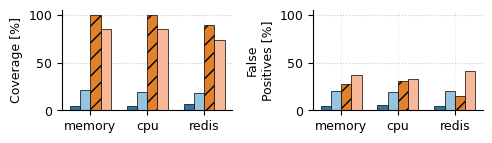

In [ ]:
# Load data
fd_data = load_data('../paper-data/sockshop-allfailures-fdsketch.csv', algorithm='FD')
vae_data = load_data('../paper-data/sockshop-allfailures-vae.csv', algorithm='VAE')
vae_data_filtered = vae_data[vae_data['type'] == 'best'].copy()

data = pd.concat([fd_data, vae_data_filtered]).reset_index(drop=True)


# Define colors for each method - blue variants for head methods, different colors for microview
colors = [
    '#3274A1',     # Darker blue for head-5
    '#94C4DF',     # Lighter blue for head-20
    # '#D55E00',
    '#E1812C',     # Orange for μView-FD
    # '#E1812C',     # Orange for μView-FD,
    # '#DE8F05'
    '#F7B799'   
]


# assign numeric Id to alogirthms to match order of colors
data['ID'] = sort_by_color(data)

methods = data['algorithm'].unique()


experiments = ['memory', 'cpu', 'redis']

# reset rc params
mpl.rcParams.update(mpl.rcParamsDefault)

# Set figure style for publication quality
plt.rcParams.update({
    'font.size': 9,
    # 'font.family': 'serif',
    'figure.figsize': (5, 1.5),
    'axes.grid': True,
    'grid.alpha': 0.3,
    'grid.linestyle': ':',
    'axes.grid.which': 'major',
    'axes.axisbelow': True
})

# Create a single figure with two subplots for better layout in publication
fig, (ax_coverage, ax_overhead) = plt.subplots(1, 2)

# Update methods list for later use
methods = data.algorithm.unique()



# Define hatches for microview methods to distinguish between them
hatches = ['', '', '//', '']  # No hatching for head methods, different hatch for microview

# Set positions for the bars
bar_width = 0.18
x = np.arange(len(experiments))

# Plot for each method
for i, method in enumerate(methods):
    # Filter data for the current method
    method_data = data[data['algorithm'] == method]
    
    # Group by experiment and get metrics - using normalized values for percentages
    coverage_values = []
    overhead_values = []
    
    for exp in experiments:
        exp_data = method_data[method_data['experiment'] == exp]
        if not exp_data.empty:
            # Use normalized values for percentages
            coverage_values.append(exp_data['coverage_norm'].values[0])
            overhead_values.append(exp_data['overhead_norm'].values[0])
        else:
            coverage_values.append(0)
            overhead_values.append(0)
    
    # Plot bars for coverage with hatching for microview methods
    ax_coverage.bar(x + (i - 1.5) * bar_width, coverage_values, 
                width=bar_width, color=colors[i], label=method, 
                hatch=hatches[i], edgecolor='black', linewidth=0.5)
    
    # Plot bars for overhead with hatching for microview methods
    ax_overhead.bar(x + (i - 1.5) * bar_width, overhead_values, 
                width=bar_width, color=colors[i], label=method,
                hatch=hatches[i], edgecolor='black', linewidth=0.5)

# Set labels and customize coverage plot
ax_coverage.set_ylabel('Coverage [%]')
ax_coverage.set_ylim(0, 105)  # Give a little headroom above 100%
ax_coverage.set_xticks(x)
ax_coverage.set_xticklabels(experiments)
ax_coverage.grid(True, linestyle=':', alpha=0.7, axis='y')
ax_coverage.spines['top'].set_visible(False)  # Hide the top spine for a cleaner look
ax_coverage.spines['right'].set_visible(False)  # Hide the right spine for a cleaner look

# Set labels and customize overhead plot
ax_overhead.set_ylabel('False\nPositives [%]')
# remove completely xlabel, not set just empty
ax_overhead.set_xlabel('')
ax_overhead.set_ylim(0, 105)  # Give a little headroom above 100%
ax_overhead.set_xticks(x)
ax_overhead.set_xticklabels(experiments)
ax_overhead.grid(True, linestyle=':', alpha=0.7, axis='y')
ax_overhead.spines['top'].set_visible(False)  # Hide the top spine for a cleaner look
ax_overhead.spines['right'].set_visible(False)  # Hide the right spine for a cleaner look

# Create a separate figure for the legend
handles, labels = ax_coverage.get_legend_handles_labels()

if not legend_despine:
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.15), 
           ncol=4, frameon=False, fontsize=9)

# Improve layout
plt.tight_layout()
# plt.subplots_adjust(top=0.85)  # Make room for the legend

# Save the figure in publication-quality formats
plt.savefig(f'{paper_dir}/coverage-overhead-sockshop.pdf', bbox_inches='tight', dpi=300,  pad_inches=0, transparent=True)
plt.savefig('../paper-data/figures/comparison_plot.png', bbox_inches='tight', dpi=300, pad_inches=0, transparent=True)

plt.show()

# Create a new figure just for the legend
fig_legend = plt.figure(figsize=(6.5, 0.5))
# Create the legend on the standalone figure with consistent styling
leg = fig_legend.legend(handles, labels, 
                    loc='center', 
                    ncol=4,        # 4 items in a row
                    frameon=False, 
                    fontsize=9)
# Remove any extra padding
fig_legend.tight_layout()

# Save the standalone legend figure in publication-quality formats
fig_legend.savefig(f'{paper_dir}/legend.pdf', bbox_inches='tight', dpi=300, transparent=True)
fig_legend.savefig('../paper-data/figures/legend.png', bbox_inches='tight', dpi=300, transparent=True)

## MicroView vs workload

Check that methods is now the order you want thigs to be plot

In [84]:
methods

array(['jaeger(5%)', 'jaeger(20%)', '$\\mu$View-FD', '$\\mu$View-VAE'],
      dtype=object)

In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

# Load FD sketch data
df_sock_fd = load_data('../paper-data/sockshop-fdsketch.csv', "FD")
df_dsb_fd = load_data('../paper-data/dsbhotel-fdskech.csv', "FD")  # Note: keeping original filename with typo

# Load VAE data
df_sock_vae = load_data('../paper-data/sockshop-vae.csv', "VAE")
df_dsb_vae = load_data('../paper-data/dsbhotel-vae.csv', "VAE")

df_sock_fd['workload'] = 'Sockshop'
df_dsb_fd['workload'] = 'DSB Hotel'
df_sock_vae['workload'] = 'Sockshop'
df_dsb_vae['workload'] = 'DSB Hotel'

# Here we only keep the sketch/VAE and discard the head sampling
df_sock_vae = df_sock_vae[df_sock_vae['type'] == 'best'].copy()
df_dsb_vae = df_dsb_vae[df_dsb_vae['type'] == 'best'].copy()

jaeger(5%)
jaeger(20%)
$\mu$View-FD
$\mu$View-VAE


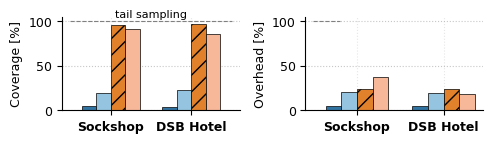

In [ ]:
# Combine all datasets
df_combined = pd.concat([
    df_sock_fd,
    df_dsb_fd,
    df_sock_vae,
    df_dsb_vae
]).sort_values(by='ID')


# Reset matplotlib parameters
mpl.rcParams.update(mpl.rcParamsDefault)

# Set figure style for publication quality
plt.rcParams.update({
    'font.size': 9,
    'figure.figsize': (5, 1.5),
    'axes.grid': True,
    'grid.alpha': 0.3,
    'grid.linestyle': ':',
    'axes.grid.which': 'major',
    'axes.axisbelow': True
})

# Create figure with two subplots
fig, (ax_coverage, ax_overhead) = plt.subplots(1, 2)

# Set positions for bars
bar_width = 0.18
workloads = ['Sockshop', 'DSB Hotel']
x = np.arange(len(workloads))

for i, method in enumerate(methods):
    print(method)
    # Filter data for the current method
    method_data = df_combined[df_combined['algorithm'] == method]
    
    # Group by workload and get metrics
    coverage_values = []
    overhead_values = []
    
    for workload in workloads:
        workload_data = method_data[method_data['workload'] == workload]
        if not workload_data.empty:
            # Use mean values if multiple entries per workload
            coverage_values.append(workload_data['coverage_norm'].mean())
            overhead_values.append(workload_data['overhead_norm'].mean())
        else:
            coverage_values.append(0)
            overhead_values.append(0)
    
    # Plot bars for coverage
    ax_coverage.bar(x + (i - 1.5) * bar_width, coverage_values, 
                    width=bar_width, color=colors[i],
                    hatch=hatches[i], edgecolor='black', linewidth=0.5)
    
    # Plot bars for overhead
    ax_overhead.bar(x + (i - 1.5) * bar_width, overhead_values, 
                    width=bar_width, color=colors[i],
                    hatch=hatches[i], edgecolor='black', linewidth=0.5)

# Set labels and customize coverage plot
ax_coverage.set_ylabel('Coverage [%]')
ax_coverage.set_ylim(0, 105)
ax_coverage.hlines(100, -0.5, 1.5, color='gray', linestyle='--', linewidth=0.8)
# Add text above the line
ax_coverage.text(0.5, 102, 'tail sampling', ha='center', va='bottom', fontsize=8)
ax_coverage.set_xticks(x)
ax_coverage.set_xticklabels(workloads)
ax_coverage.grid(True, linestyle=':', alpha=0.7, axis='y')
ax_coverage.spines['top'].set_visible(False)
ax_coverage.spines['right'].set_visible(False)
# set bold font on x-axis
for t in ax_coverage.get_xticklabels():
    t.set_fontweight('bold')

# Set labels and customize overhead plot
ax_overhead.set_ylabel('Overhead [%]')
ax_overhead.set_ylim(0, 105)  # Adjust as needed for your data
ax_overhead.set_xticks(x)
ax_overhead.set_xticklabels(workloads)
ax_overhead.hlines(100, -0.5, -0.2, color='gray', linestyle='--', linewidth=0.8)

# set bold font on x-axis
for t in ax_overhead.get_xticklabels():
    t.set_fontweight('bold')
ax_overhead.grid(True, linestyle=':', alpha=0.7, axis='y')
ax_overhead.spines['top'].set_visible(False)
ax_overhead.spines['right'].set_visible(False)

# Improve layout
plt.tight_layout()

# Save the figure
plt.savefig(f'{paper_dir}/workload-comparison.pdf', bbox_inches='tight', dpi=300, pad_inches=0, transparent=True)
plt.savefig('../paper-data/figures/workload-comparison.png', bbox_inches='tight', dpi=300, pad_inches=0, transparent=True)

plt.show()